In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as sps
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

from statsmodels.stats.proportion import proportion_confint
from statsmodels.api import nonparametric as npar
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.3, palette='Set2')

%matplotlib inline

### Задача 1



Рассмотрим данные по транзакциям одного из интернет-магазинов: https://www.kaggle.com/datasets/jihyeseo/online-retail-data-set-from-uci-ml-repo

Скачаем данные и оставим следующие колонки:
* `Quantity` &mdash; количество данной единицы товара в чеке.
* `InvoiceDate` &mdash; дата и время покупки.
* `UnitPrice` &mdash; цена одной единицы товара.
* `CustomerID` &mdash; уникальный идентификатор клиента.

In [ ]:
data = pd.read_excel('Online Retail.xlsx')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Оставим только необходимые колонки

In [ ]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data = data.iloc[:, 3:7]
data['Price'] = data['Quantity'] * data['UnitPrice']
data.head()

,Quantity,InvoiceDate,UnitPrice,CustomerID,Price
0,6,2010-12-01 08:26:00,2.55,17850.0,15.30
1,6,2010-12-01 08:26:00,3.39,17850.0,20.34
2,8,2010-12-01 08:26:00,2.75,17850.0,22.00
3,6,2010-12-01 08:26:00,3.39,17850.0,20.34
4,6,2010-12-01 08:26:00,3.39,17850.0,20.34


Магазин хочет провести AB-тест в течение двух месяцев для оценки значимости эффекта от нового блока умных рекомендаций и использовать для этого *относительный* t-test. Ожидается, что новый блок рекомендаций увеличит общую выручку. На время тестирования решено выкатить блок рекомендаций на случайную группу из 300 пользователей.

**1.**
Проверим наш тест на реальных данных. На данных за апрель и май проведем множество случайных AA-тестов для оценки вероятности ошибки I рода, выбирая случайных пользователей в каждую из групп. Использовать нужно группы одинакого размера, и, конечно же, они не должны пересекаться. Для каждого пользователя рассматриваем общую сумму его покупок за два месяца.

In [ ]:
def relative_ttest(x, y, target_column, alpha=0.05):
    '''
    Относительный t-test.

    Аргументы:
    x, y -- выборки одинакового размера
    target_column -- колонка, соответствующаяя таргет-метрике
    alpha -- уровень значимости

    Возвращает:
    stat -- статистика критерия
    pvalue
    left_bound, right_bound -- границы дов. интервала
    '''

    n = len(x)
    x_mean = x[target_column].mean()
    y_mean = y[target_column].mean()

    stat = x_mean/y_mean - 1
    var = x[target_column].var() / (y_mean**2) \
            + y[target_column].var() * (x_mean**2) / (y_mean**4)
    std = np.sqrt(var)

    z_stat = np.sqrt(n) * stat / std
    pvalue = 2*sps.norm.sf(np.abs(z_stat))

    q = sps.norm.ppf(1 - alpha/2)
    left_bound = stat - q*std/np.sqrt(n)
    right_bound = stat + q*std/np.sqrt(n)

    return stat, pvalue, left_bound, right_bound

In [ ]:
def run_experiments_AA(test, generate_sample, data=None, n_iter=10000, alpha=0.05,
                       show_pvals=False):
    '''
    Проведение серии AA-тестов:
        * либо на исторических данных data
        * либо на искусственных данных

    Аргументы:
    test -- статистический критерий
    generate_sample -- функция для семплирования/генерации выборок
    data -- исторические данные, на которых запускаем АА-тест.
        None, если используем искусственные данные
    n_iter -- количество итераций
    alpha -- теоретический уровень значимости
    show_pvals -- показывать ли распределение p-value

    Возвращает:
    type_1_prob_est -- оценка вероятности ошибки первого рода
    left_bound, right_bound -- границы доверительного интервала
    '''

    n_rejects = 0  # количество отвержений H_0
    pvals = []

    # Проведение экспериментов
    for _ in tqdm(range(n_iter)):
        # Генерируем выборки
        x, y = generate_sample() if data is None else generate_sample(data)
        # Применияем критерий
        pvals.append(test(x, y)[1])
        n_rejects += (pvals[-1] < alpha)


    # Оценка вероятности ошибки первого рода
    type_1_prob_est, left_bound, right_bound = estimate_reject_prob(n_rejects, n_iter)

    # Визуализация
    figsize = (14, 3) if show_pvals else (5, 2)
    visualization(type_1_prob_est, left_bound, right_bound, show_pvals, pvals,
                  alpha, figsize)
    return type_1_prob_est, (left_bound, right_bound)


def generate_data_from_distrs(distr1, distr2, sample_size=1000):
    '''
    Генерация искусственных данных из распределений

    Аргументы:
    distr1, distr2 -- распределения данных теста и контроля
    sample_size -- размер выборок

    Возвращает:
    x, y -- выборки
    '''
    x = distr1.rvs(size=sample_size)
    y = distr2.rvs(size=sample_size)
    return x, y



def visualization(prob_reject, left_bound, right_bound,
                  show_pvals=False, pvals=None, alpha=0.05, figsize=(7, 2)):
    '''
    Отрисовка интервала для вероятности отвержения критерия
    и гистограммы p-value (опционально)
    prob_reject -- оценка вероятности отвержения
    left_bound, right_bound -- границы доверительного интервала
    alpha -- теоретический уровень значимости
    show_pvals -- показывать ли распределение p-value
    pvals -- массив из p-value
    figsize -- размер фигуры matplotlib
    '''

    # построение гистограммы p-value (опционально)
    if show_pvals:
        with sns.axes_style("whitegrid"):
            plt.figure(figsize=figsize)
            plt.subplot(1, 2, 1)
            plt.hist(pvals, bins=np.linspace(0, 1, 21), alpha=0.7,
                    weights=np.ones(len(pvals)) / len(pvals))
            plt.title('Распределение p-value')

    # отрисовка интервала для вероятности отвержения критерия
    with sns.axes_style("whitegrid"):
        if show_pvals:
            plt.subplot(1, 2, 2)
        else:
            plt.figure(figsize=figsize)
        plt.hlines(0, 0, 1, color='black', lw=2, alpha=0.6)
        plt.vlines(alpha, -1, 1, color='red', lw=5, linestyle='--', alpha=0.6)
        plt.fill_between(
            [left_bound, right_bound], [0.15]*2, [-0.15]*2,
            color='green', alpha=0.6
        )
        plt.scatter(prob_reject, 0, s=300, marker='*', color='red')
        plt.xlim((min(alpha, left_bound)-1e-3, max(alpha, right_bound)+1e-3))
        plt.title(
            f'Доля отвержений = {100*prob_reject:.2f}%, '
            f'интервал ({100*left_bound:.2f}%, {100*right_bound:.2f}%)'
        )
        plt.ylim((-0.5, 0.5))
        plt.yticks([])
        plt.tight_layout()
        plt.show()


def estimate_reject_prob(n_rejects, n_iter):
    '''
    Оценка вероятности отвержения критерия и ее дов. интервала.
    Используется для оценки вероятности ошибки первого рода и мощности

    Аргументы:
    n_rejects -- количество отвержений H_0 в эксперименте
    n_iter -- количество экспериментов

    Возвращает:
    prob_reject -- оценка вероятности отвержения критерия
    left_bound, right_bound -- границы соотв. дов. интервала
    '''

    prob_reject = n_rejects / n_iter
    left_bound, right_bound = proportion_confint(n_rejects, n_iter, method='wilson')

    return prob_reject, left_bound, right_bound

In [ ]:
def run_experiments(test, generate_sample, add_effect, data=None, effects=[0],
            n_iter=10000, alpha=0.05):
    '''
    Проведение серии AB-тестов:
        * либо на исторических данных data
        * либо на искусственных данных

    Аргументы:
    test -- статистический критерий
    generate_sample -- функция для семплирования/генерации выборок
    add_effect -- функция для искусственного добавления эффекта в тестовую выборку
    data -- исторические данные, на которых запускаем АА-тест.
        None, если используем искусственные данные
    effect_arr -- массив искусственно добавляемых эффектов
    n_iter -- количество итераций
    alpha -- теоретический уровень значимости

    Возвращает:
    real_alpha -- оценка уровня значимости
    left_alpha, right_alpha -- границы доверительного интервала
    '''

    n_rejects = np.zeros(len(effects))  # количество отвержений H_0

    # Проведение экспериментов
    for num_effect, effect in tqdm(enumerate(effects)):
        for _ in range(n_iter):
            # Генерируем выборки
            x, y = generate_sample() if data is None else generate_sample(data)
            # Добавляем эффект
            x = add_effect(x, effect)
            # Применияем критерий
            n_rejects[num_effect] += (test(x, y)[1] < alpha)

    # Реальная мощность
    real_power, left_power, right_power = estimate_reject_prob(n_rejects, n_iter)
    # Отрисовка мощности
    draw_power(effects, real_power, left_power, right_power)
    return real_power, (left_power, right_power)


def add_effect(x, effect):
    '''
    Функция искусственного добавления эффекта в тестовую выборку

    Аргументы:
    x -- выборка
    effect -- добавляемый эффект

    Возвращает:
    x -- выборка с добавленным эффектом
    '''

    x += effect
    return x


def draw_power(effects, real_power, left_power, right_power, title='График мощности'):
    '''
    Построение и отрисовка графика мощности критерия.

    Аргументы:
    effects -- сетка эффектов
    real_alpha -- оценка реальной мощности
    left_alpha, right_alpha -- границы соотв. дов. интервала
    title -- заголовок графика
    '''

    plt.figure(figsize=(5, 2))
    plt.plot(effects, real_power, label='Мощность', lw=3)
    plt.fill_between(effects, left_power, right_power, alpha=0.3,
                     label='Дов. интервал мощности')
    plt.hlines(0.8, effects[0], effects[-1], color='black', alpha=0.5,
               label='Мощность 0.8 (пересечение - MDE)')
    plt.legend()
    plt.xlabel('Размер относительного эффекта')
    plt.ylabel('Мощность')
    plt.title(title)
    plt.show()

Возьмем данные за нужные месяцы и сгруппируем данные по клиентам. Таким образом мы получим данные по среднему чеку на человека за рассматриваемые 2 месяца.

In [ ]:
data_m = data.copy()
data_m['Month'] = data['InvoiceDate'].apply(lambda x: x.month)
data_m = data_m[(data_m['Month'] > 3) & (data_m['Month'] < 6)]
data_m = data_m[['CustomerID', 'Price']].groupby(['CustomerID']).sum().reset_index()
data_m.head()

,CustomerID,Price
0,12347.0,636.25
1,12348.0,367.00
2,12353.0,89.00
3,12354.0,1079.40
4,12355.0,459.40


Посмотрим на гистограмму распределения среднего чека на человека.

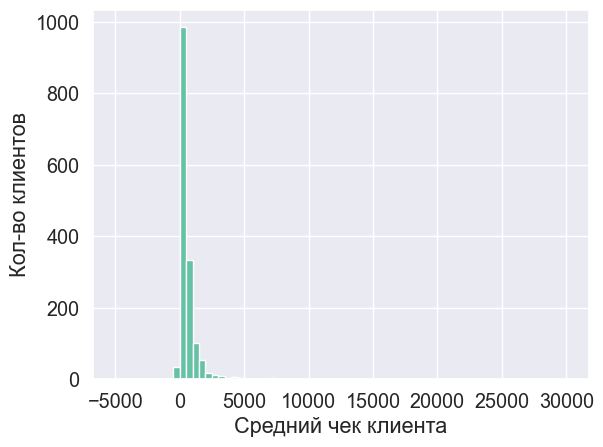

In [ ]:
data_m['Price'].hist(bins=np.linspace(-5000, 30000, 71))
plt.xlabel('Средний чек клиента')
plt.ylabel('Кол-во клиентов');

Видны явные выбросы:
* пользователи, которые тратят очень много (до 30 тыс.)
* пользователи с отрицательными тратами

Посмотрим подробнее на клиентов, чьи траты от 0 до 5 тыс.

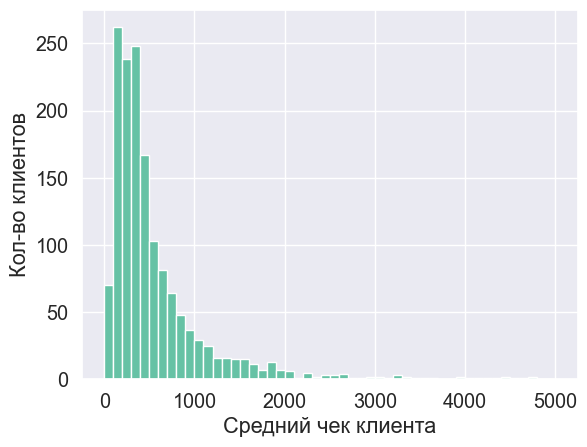

In [ ]:
data_m['Price'].hist(bins=np.linspace(0, 5000, 51))
plt.xlabel('Средний чек клиента')
plt.ylabel('Кол-во клиентов');

Пользователи, имеющие отрицательную сумму покупок, скорее всего, оформляли возврат. Так как мы хотим посчитать выручку, то возвраты тоже должны учитывать, поэтому не будем удалять польльзователей с отрицательными суммами.

Посмотрим, какая доля этих пользователей

In [ ]:
(data_m['Price'] < 0).mean()

0.023432552248258392

In [ ]:
group_size = 300 # размер группы
n_iter = 200_000  # количество итераций в одном эксперименте
alpha = 0.05  # уровень значимости

In [ ]:
def generate_from_data(data, size_gen=None):
    '''
    Генерация выборок 2-x групп фиксированного размера из данных

    Аргументы:
    data -- данные
    size_gen -- размер теста/контроля. Если None, то генерация половины от всех в каждую группу

    Возвращает:
    test, control -- тестовая и контрольная группы
    '''

    if size_gen is None:
        size_gen = int(len(data) // 2) # Если None, то генерируем половину от всех

    # Генерируем индексы теста
    test_inds = np.random.choice(len(data), size_gen, replace=False)
    other_inds = list(set(np.arange(len(data))) - set(test_inds))
    # Генерируем индексы контроля из оставшихся
    control_inds = np.random.choice(other_inds, size_gen, replace=False)
    test = data.iloc[test_inds]
    control = data.iloc[control_inds]
    return test, control

Серия AA-тестов

In [ ]:
target_column = 'Price'

  0%|          | 0/200000 [00:00<?, ?it/s]

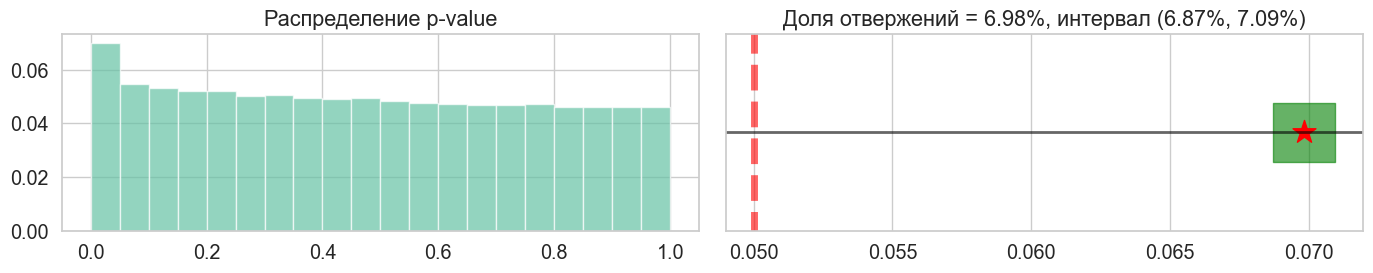

In [ ]:
run_experiments_AA(test= lambda x, y: relative_ttest(x, y, target_column=target_column),
        generate_sample=lambda data: generate_from_data(data, size_gen=group_size),
        data=data_m,
        n_iter=n_iter,
        alpha=alpha,
        show_pvals=True
);

Критерий не работает, его нельзя применять. Есть предположение, что играют роль выбросы (так как t-test неустойчив к выбросам), а также наличие отрицательных значений (напомним, что относительный t-test корректно работает с положительными выборками).

Проверим, а корректно ли работает обычный t-test.

  0%|          | 0/200000 [00:00<?, ?it/s]

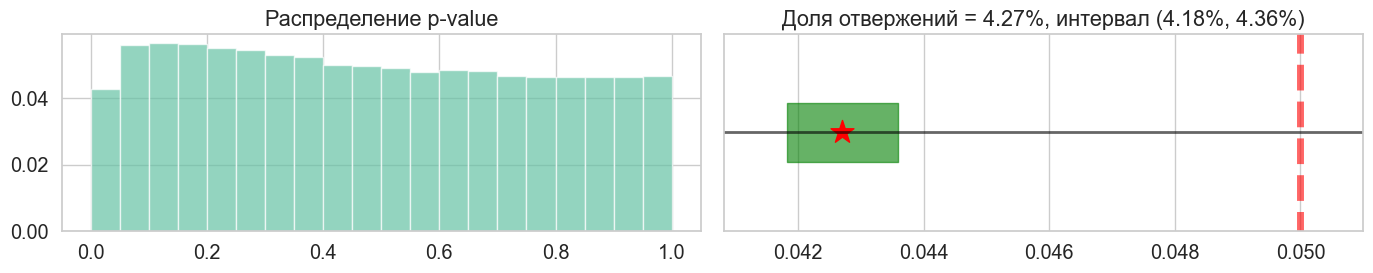

In [ ]:
run_experiments_AA(test= lambda x, y: sps.ttest_ind(x[target_column], y[target_column]),
        generate_sample=lambda data: generate_from_data(data, size_gen=group_size),
        data=data_m,
        n_iter=n_iter,
        alpha=alpha,
        show_pvals=True
);

Обычный t-test работает корректно, однако у него немного занижена вероятность ошибки первого рода, что может негативно сказаться на мощности.

**2.** С помощью проведения AB-теста по историческим данных выясним, какова мощность теста для разных значений эффекта. Схема проведения аналогична предыдущему пункту, но к тестовой группе нужно добавить положительное смещение.

**Ответ:** искусственное смещение может быть полезно, если эффект на разных пользователей неодинаков.

Посмотрим разброс цены

In [ ]:
data_m['Price'].describe()

count    1.539000e+03
mean     7.022965e+02
std      1.514851e+03
min      5.684342e-14
25%      2.230850e+02
50%      3.732700e+02
75%      6.879600e+02
max      3.138470e+04
Name: Price, dtype: float64

Серия AB-тестов

Немного перепишем функцию добавления эффекта: будем добавлять относительный эффект и шум для каждого пользователя.

In [ ]:
def add_effect_with_noise(x, effect, target_column):
    '''
    Функция искусственного добавления эффекта в тестовую выборку

    Аргументы:
    x -- выборка
    effect -- добавляемый эффект

    Возвращает:
    x -- выборка с добавленным эффектом
    '''

    x_copy = x.copy()
    x_copy[target_column] = x_copy[target_column] * (1 + effect) + sps.norm(loc=0,
                                            scale=np.abs(x_copy[target_column]) / 100).rvs()
    return x_copy

In [ ]:
n_iter = 50_000
effects = np.linspace(0, 0.6, 21)

0it [00:00, ?it/s]

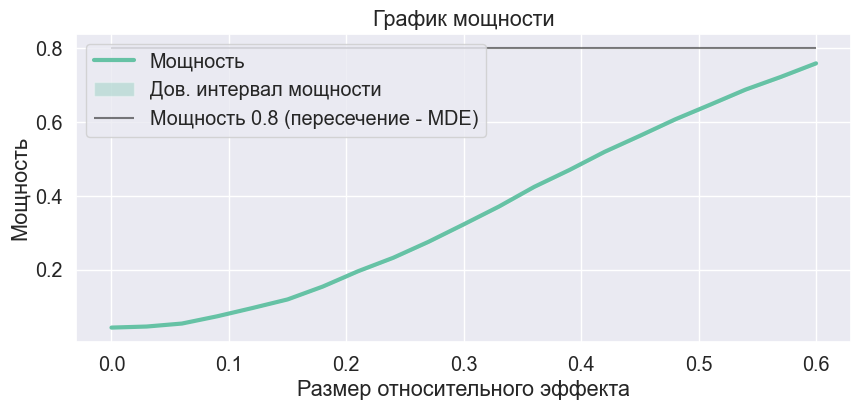

In [ ]:
run_experiments(test= lambda x, y: sps.ttest_ind(x[target_column], y[target_column]),
        generate_sample=lambda data: generate_from_data(data, size_gen=group_size),
        data=data_m,
        effects=effects,
        add_effect=lambda x, e: add_effect_with_noise(x, e, target_column=target_column),
        n_iter=n_iter,
        alpha=alpha
);

**Вывод:** мы провели тесты на исторических данных и оценили вероятность ошибки первого рода и мощность критериев. У относительного t-test вероятность ошибки первого рода превышает заданное значение, значит, такой критерий некорректен в данном случае. У абсолютного t-test вероятность ошибки первого рода немного занижена, как следствие, и мощность не самая лучшая: при искусственном увеличении метрик тестовой группы даже в среднем на $60\%$ мощность не доходит до $0.8$. Скорее всего, роль играют небольшие размеры выборок, а также наличие выбросов в данных, что сильно увеличивает дисперсию данных. На следующих занятиях мы рассмотрим, что делать в таких случаях, и будем увеличивать чувствительность критериев (то есть, увеличивать их мощность).

---
### Задача 2.

Рассмотрим t-test в абсолютной и относительной постановке. При использовании данных критериев предполагается, что статистика критерия (не сама выборка) приближенно имеет нормальное распределение. Но на практике ее распределение может значительно отличаться от нормального. В таком случае на помощь может прийти бутстреп.

Опишем процедуру реализации с помощью бутстрепа критериев на основе статистик из t-test в абсолютной и относительной постановке.

**Описание:**
1. Бутстрепные итерации:
  * Семплируем бутстрепные выборки
  * Считаем бутстрепную статистику
2. По бутстрепной выборке статистик считаем:
  * квантильный интервал
  * p-value

Сколько бутстрепных выборок необходимо взять?

**Ответ:** Как можно больше. Точно не меньше, чем объем данных, чтобы не ухудшить асимптотику.

Какие основные преимущества и недостатки использования бутстрепных критериев?

**Ответ:**

*Преимущество:* не нужно думать над распределением статистики.

*Недостаток:* требуется много вычислительных ресурсов

Реализуем эту процедуру.

In [ ]:
def ttest_bootstrap(
    x, y, B=100000, alpha=0.05, relative=False, return_bootstrap_stats=False):
    '''
    Относительный t-test.

    Аргументы:
    x, y -- выборки одинакового размера
    B -- количество бутстрепных выборок
    alpha -- уровень значимости
    return_bootstrap_stats -- возвращать ли бутстрепную выборку статистик
    relative -- использовать относительную статистику или абсолютную

    Возвращает:
    stat -- статистика критерия
    left_bound, right_bound -- границы дов. интервала
    pvalue
    bootstrap_stats -- если return_bootstrap_stats = True
    '''

    x = np.array(x)
    y = np.array(y)
    n = len(x)

    # Выбираем сразу все выборки
    x_boot = np.random.choice(x, size=(B, n), replace=True)
    y_boot = np.random.choice(y, size=(B, n), replace=True)

    # Считаем статистики
    if relative:
        bootstrap_stats = x_boot.mean(axis=1)/y_boot.mean(axis=1) - 1
        stat = x.mean() / y.mean() - 1
    else:
        bootstrap_stats = x_boot.mean(axis=1) - y_boot.mean(axis=1)
        stat = x.mean() - y.mean()

    # Границы интервала
    left_bound = np.quantile(bootstrap_stats, alpha/2)
    right_bound = np.quantile(bootstrap_stats, 1 - alpha/2)

    pvalue = 2 * min((bootstrap_stats > 0).mean(), (bootstrap_stats < 0).mean())

    if return_bootstrap_stats:
        return stat, pvalue, left_bound, right_bound, bootstrap_stats
    else:
        return stat, pvalue, left_bound, right_bound

Проведем исследование реализованных критериев  

Немного изменим функции тестирования, добавив в визуализацию бутстрепную оценку распределения статистики и сравнение ее с нормальным распределением.

In [ ]:
def run_experiments_AA(test, generate_sample, data=None, n_iter=10000, alpha=0.05,
                       show_pvals=False):
    '''
    Проведение серии AA-тестов:
        * либо на исторических данных data
        * либо на искусственных данных

    Аргументы:
    test -- статистический критерий
    generate_sample -- функция для семплирования/генерации выборок
    data -- исторические данные, на которых запускаем АА-тест.
        None, если используем искусственные данные
    n_iter -- количество итераций
    alpha -- теоретический уровень значимости
    show_pvals -- показывать ли распределение p-value

    Возвращает:
    type_1_prob_est -- оценка вероятности ошибки первого рода
    left_bound, right_bound -- границы доверительного интервала
    '''

    n_rejects = 0  # количество отвержений H_0
    pvals = []

    # Проведение экспериментов
    for _ in tqdm(range(n_iter)):
        # Генерируем выборки
        x, y = generate_sample() if data is None else generate_sample(data)
        # Применияем критерий
        stat, pvalue, lb, rb, bootstrap_stats = test(x, y)
        pvals.append(pvalue)
        n_rejects += (pvalue < alpha)


    # Оценка вероятности ошибки первого рода
    type_1_prob_est, left_bound, right_bound = estimate_reject_prob(n_rejects, n_iter)

    # Визуализация
    figsize = (14, 3) if show_pvals else (5, 2)
    visualization(type_1_prob_est, left_bound, right_bound, bootstrap_stats,
                  show_pvals, pvals, alpha, figsize)
    return type_1_prob_est, (left_bound, right_bound)


def generate_data_from_distrs(distr1, distr2, sample_size=1000):
    '''
    Генерация искусственных данных из распределений

    Аргументы:
    distr1, distr2 -- распределения данных теста и контроля
    sample_size -- размер выборок

    Возвращает:
    x, y -- выборки
    '''
    x = distr1.rvs(size=sample_size)
    y = distr2.rvs(size=sample_size)
    return x, y


def approx_normal_distribution():
    # Generate some data for this demonstration.
    data = norm.rvs(10.0, 2.5, size=500)

    # Fit a normal distribution to the data:
    mu, std = norm.fit(data)

    # Plot the histogram.
    plt.hist(data, bins=25, density=True, alpha=0.6, color='g')

    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
    plt.title(title)

    plt.show()


def visualization(prob_reject, left_bound, right_bound, statistics,
                  show_pvals=False, pvals=None, alpha=0.05, figsize=(7, 2)):
    '''
    Отрисовка интервала для вероятности отвержения критерия
    и гистограммы p-value (опционально)
    prob_reject -- оценка вероятности отвержения
    left_bound, right_bound -- границы доверительного интервала
    alpha -- теоретический уровень значимости
    show_pvals -- показывать ли распределение p-value
    pvals -- массив из p-value
    figsize -- размер фигуры matplotlib
    '''

    # построение гистограммы p-value (опционально)
    if show_pvals:
        with sns.axes_style("whitegrid"):
            plt.figure(figsize=figsize)
            plt.subplot(1, 2, 1)
            plt.hist(pvals, bins=np.linspace(0, 1, 21), alpha=0.7,
                    weights=np.ones(len(pvals)) / len(pvals))
            plt.title('Распределение p-value')

    # отрисовка интервала для вероятности отвержения критерия
    with sns.axes_style("whitegrid"):
        if show_pvals:
            plt.subplot(1, 2, 2)
        else:
            plt.figure(figsize=figsize)
        plt.hlines(0, 0, 1, color='black', lw=2, alpha=0.6)
        plt.vlines(alpha, -1, 1, color='red', lw=5, linestyle='--', alpha=0.6)
        plt.fill_between(
            [left_bound, right_bound], [0.15]*2, [-0.15]*2,
            color='green', alpha=0.6
        )
        plt.scatter(prob_reject, 0, s=300, marker='*', color='red')
        plt.xlim((min(alpha, left_bound)-1e-3, max(alpha, right_bound)+1e-3))
        plt.title(
            f'Доля отвержений = {100*prob_reject:.2f}%, '
            f'интервал ({100*left_bound:.2f}%, {100*right_bound:.2f}%)'
        )
        plt.ylim((-0.5, 0.5))
        plt.yticks([])
        plt.tight_layout()

    with sns.axes_style('whitegrid'):
        sns.displot(statistics, kind="kde", color='orange', lw=3,
                    label='Бутстрепная стат.',
                    height=3, aspect=2)

        mean, std = sps.norm.fit(statistics)
        grid = np.linspace(statistics.min(), statistics.max(), 100)
        plt.plot(grid, sps.norm(mean, std).pdf(grid), color='green', lw=3,
                 label='Норм. распределение')
        plt.xlabel('Значение статистики')
        plt.ylabel('Плотность распределения')

    plt.legend()
    plt.show()


def estimate_reject_prob(n_rejects, n_iter):
    '''
    Оценка вероятности отвержения критерия и ее дов. интервала.
    Используется для оценки вероятности ошибки первого рода и мощности

    Аргументы:
    n_rejects -- количество отвержений H_0 в эксперименте
    n_iter -- количество экспериментов

    Возвращает:
    prob_reject -- оценка вероятности отвержения критерия
    left_bound, right_bound -- границы соотв. дов. интервала
    '''

    prob_reject = n_rejects / n_iter
    left_bound, right_bound = proportion_confint(n_rejects, n_iter, method='wilson')

    return prob_reject, left_bound, right_bound

# Проверка корректности.

## 1. Эксперименты на искусственных данных

### a. Абсолютный бутстрепный t-test.

In [ ]:
def vizualize_distributions(distr1, distr2):
    '''
    Функция для отрисовки распределений, из которых генерируются
    искусственные данные

    Аргументы:
    distr1, distr2 -- распределения
    '''

    plt.figure(figsize=(5, 3))
    for i, d, label in zip([0, 1], [distr1, distr2], ['A', 'B']):
        grid = np.linspace(d.ppf(0.005) - 0.2, d.ppf(0.995) + 0.2, 1000)
        plt.plot(grid, d.pdf(grid), label=label, lw=4 - 2 * i)
    plt.legend()
    plt.title('Плотности выборок')

In [ ]:
n_iter = 2_000  # количество итераций в одном эксперименте
alpha = 0.05  # уровень значимости

#### Экспоненциальное распределение

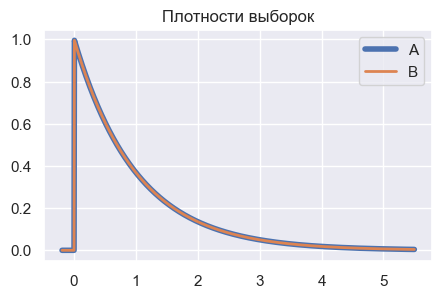

In [ ]:
vizualize_distributions(sps.expon, sps.expon)

Размер выборки: 10


  0%|          | 0/2000 [00:00<?, ?it/s]

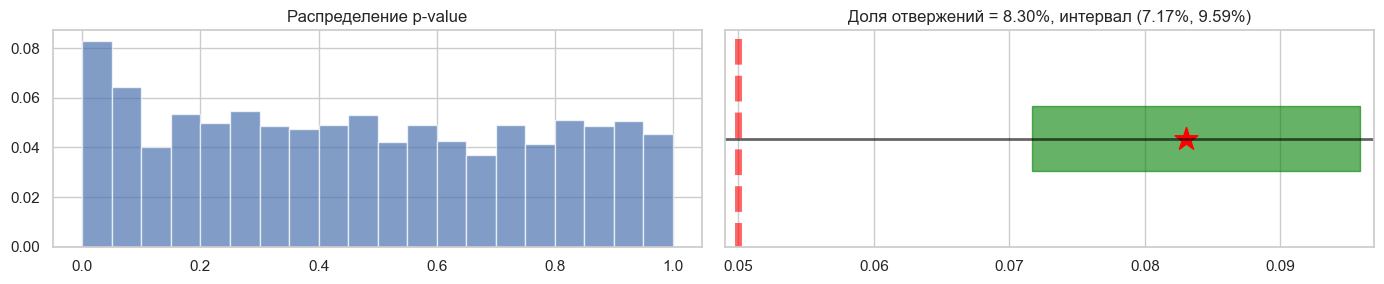

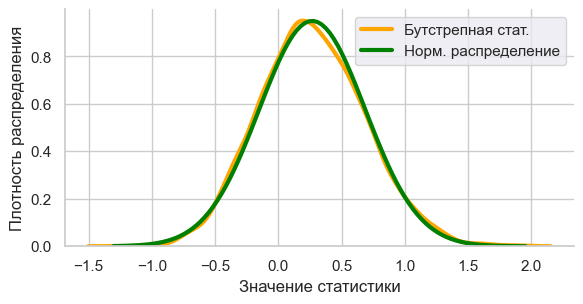

Размер выборки: 100


  0%|          | 0/2000 [00:00<?, ?it/s]

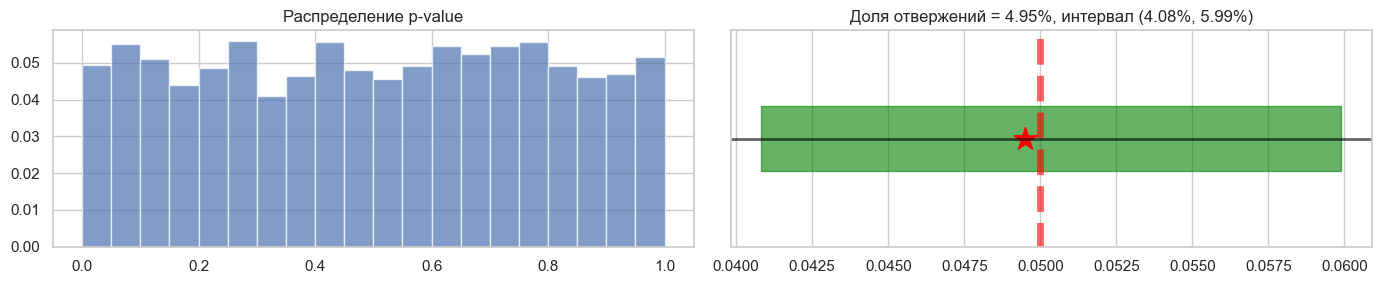

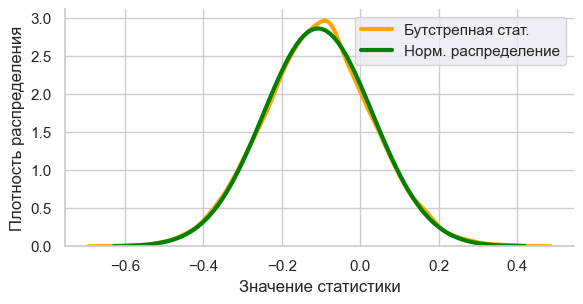

Размер выборки: 1000


  0%|          | 0/2000 [00:00<?, ?it/s]

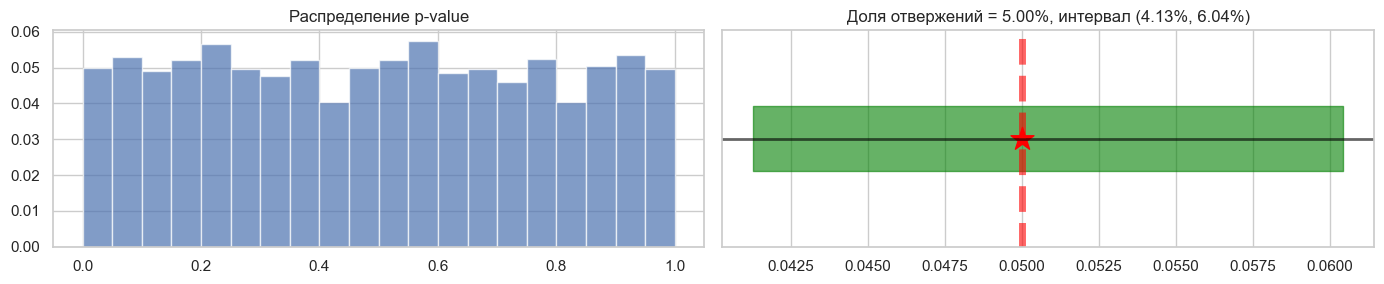

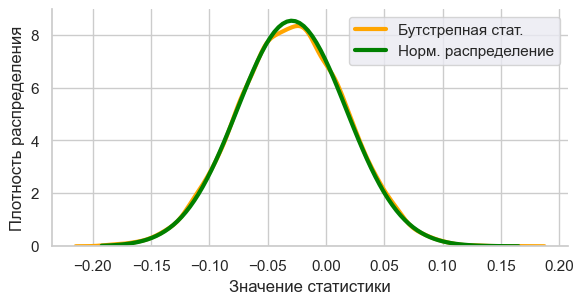

In [ ]:
sample_sizes = [10, 100, 1000]
for sample_size in sample_sizes:
    print(f'Размер выборки: {sample_size}')
    run_experiments_AA(test=lambda x, y: ttest_bootstrap(x, y, B=10_000,
                                        relative=False, return_bootstrap_stats=True),
            generate_sample=lambda: generate_data_from_distrs(sps.expon, sps.expon,
                                                              sample_size=sample_size),
            n_iter=n_iter,
            alpha=alpha,
            show_pvals=True
    );

#### Гамма-распределение

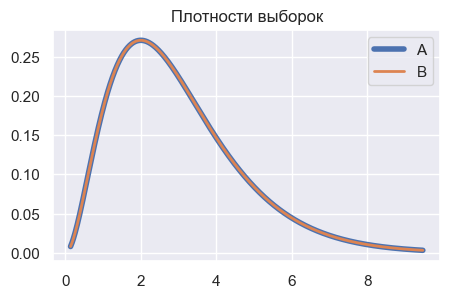

In [ ]:
vizualize_distributions(sps.gamma(a=3), sps.gamma(a=3))

Размер выборки: 10


  0%|          | 0/2000 [00:00<?, ?it/s]

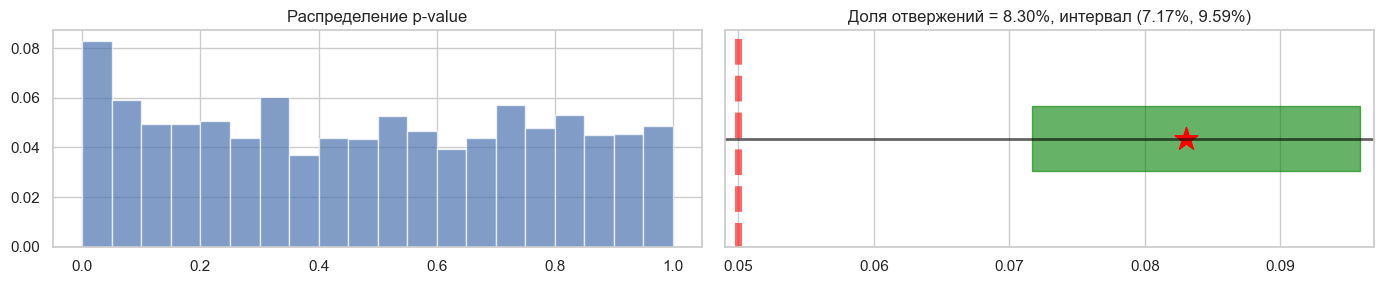

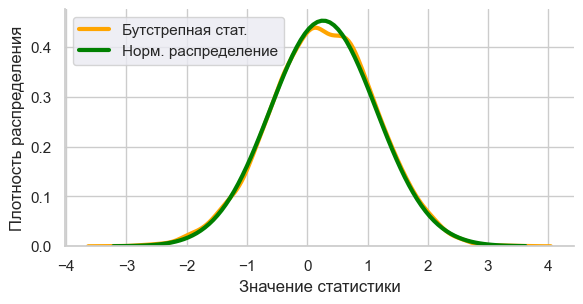

Размер выборки: 100


  0%|          | 0/2000 [00:00<?, ?it/s]

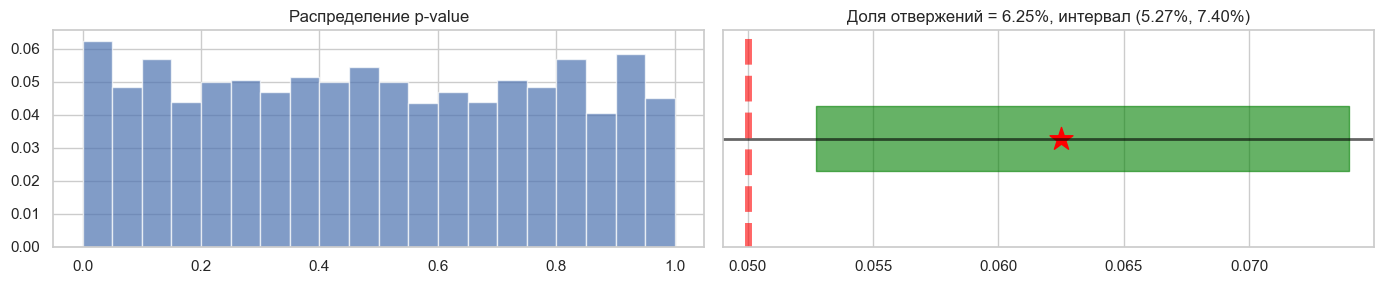

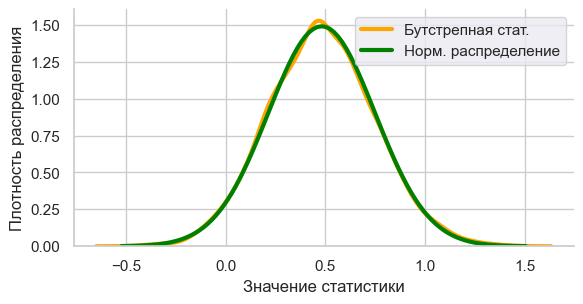

Размер выборки: 1000


  0%|          | 0/2000 [00:00<?, ?it/s]

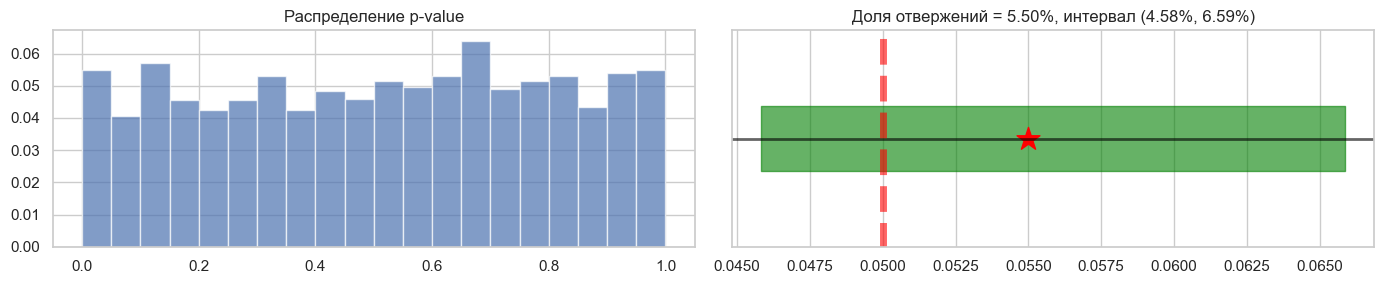

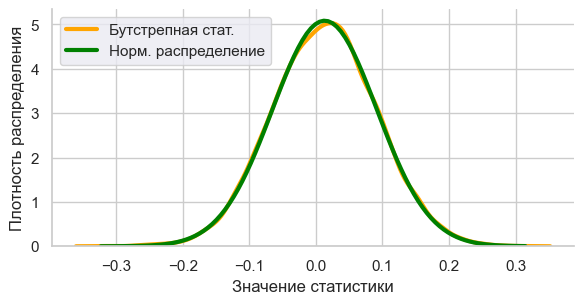

In [ ]:
sample_sizes = [10, 100, 1000]
for sample_size in sample_sizes:
    print(f'Размер выборки: {sample_size}')
    run_experiments_AA(test=lambda x, y: ttest_bootstrap(x, y, B=10_000,
                                        relative=False, return_bootstrap_stats=True),
            generate_sample=lambda: generate_data_from_distrs(sps.gamma(a=3), sps.gamma(a=3),
                                                              sample_size=sample_size),
            n_iter=n_iter,
            alpha=alpha,
            show_pvals=True
    );

#### Распределение Коши

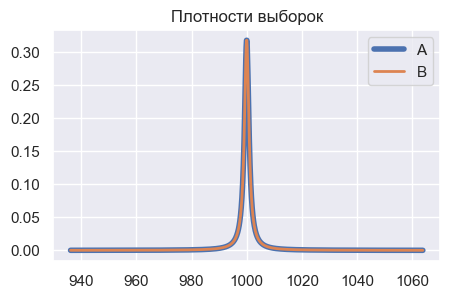

In [ ]:
vizualize_distributions(sps.cauchy(loc=1000), sps.cauchy(loc=1000))

Размер выборки: 10


  0%|          | 0/2000 [00:00<?, ?it/s]

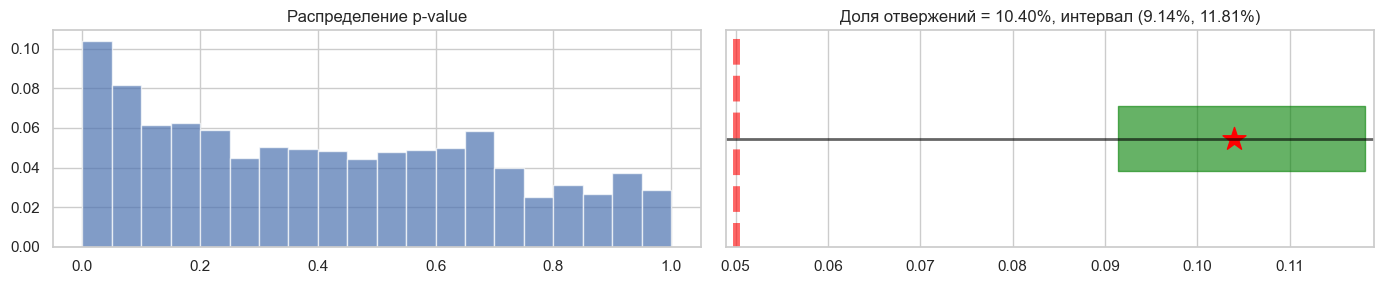

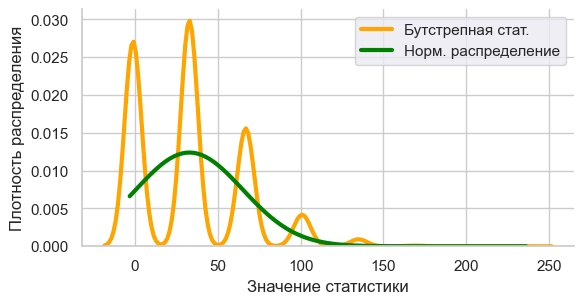

Размер выборки: 100


  0%|          | 0/2000 [00:00<?, ?it/s]

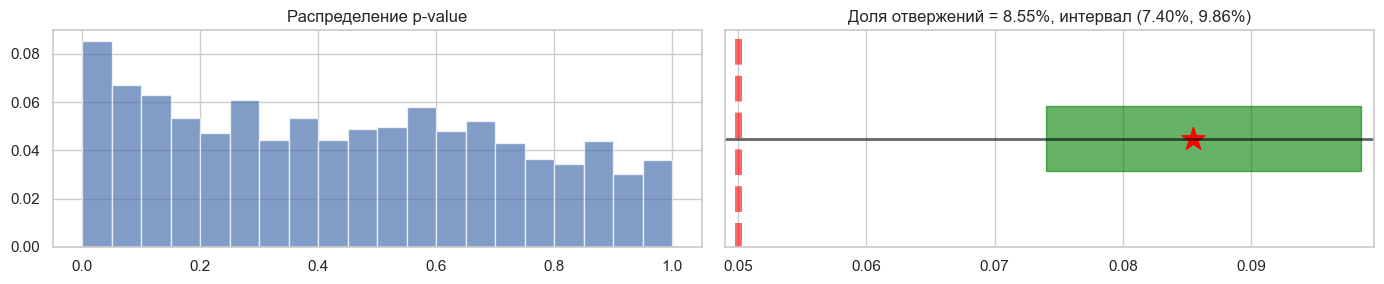

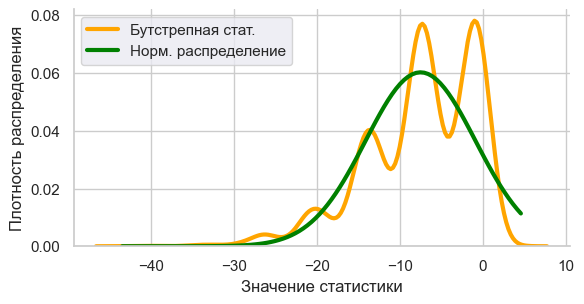

Размер выборки: 1000


  0%|          | 0/2000 [00:00<?, ?it/s]

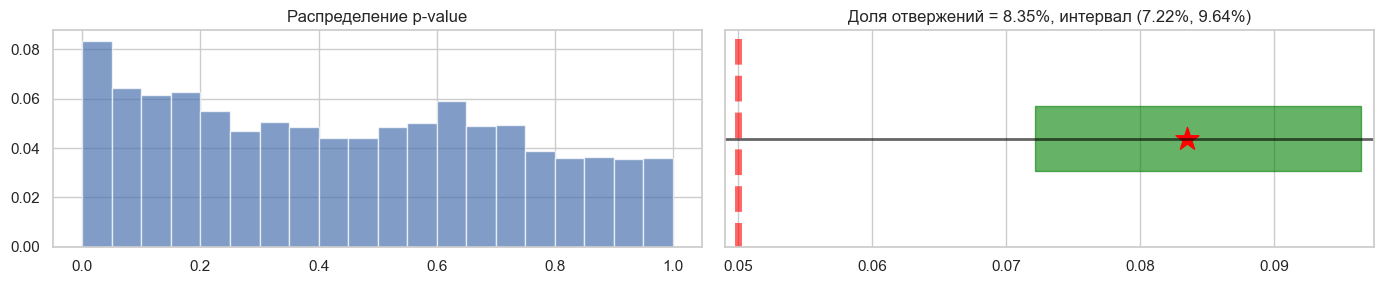

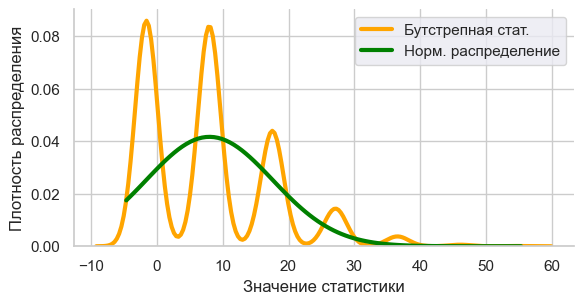

In [ ]:
sample_sizes = [10, 100, 1000]
for sample_size in sample_sizes:
    print(f'Размер выборки: {sample_size}')
    run_experiments_AA(test=lambda x, y: ttest_bootstrap(x, y, B=10_000,
                                        relative=False, return_bootstrap_stats=True),
            generate_sample=lambda: generate_data_from_distrs(sps.cauchy(loc=1000),
                                                              sps.cauchy(loc=1000),
                                                              sample_size=sample_size),
            n_iter=n_iter,
            alpha=alpha,
            show_pvals=True
    );

#### Нормальное распределение

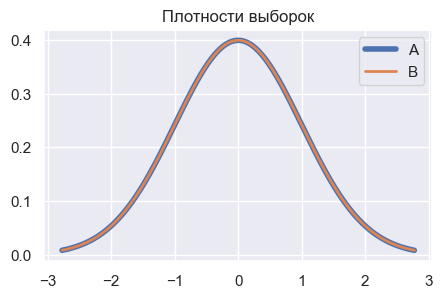

In [ ]:
vizualize_distributions(sps.norm, sps.norm)

Размер выборки: 10


  0%|          | 0/2000 [00:00<?, ?it/s]

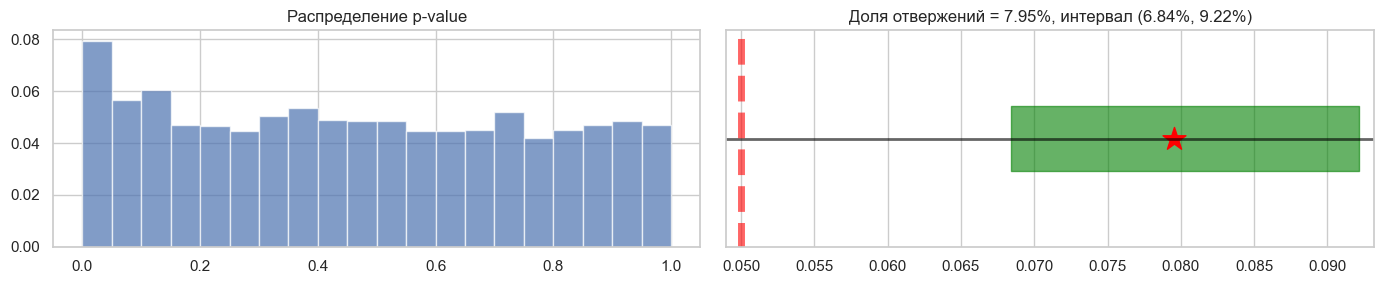

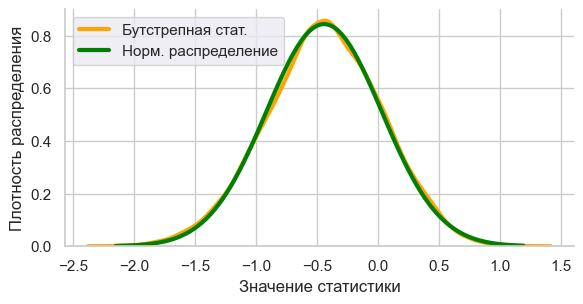

Размер выборки: 100


  0%|          | 0/2000 [00:00<?, ?it/s]

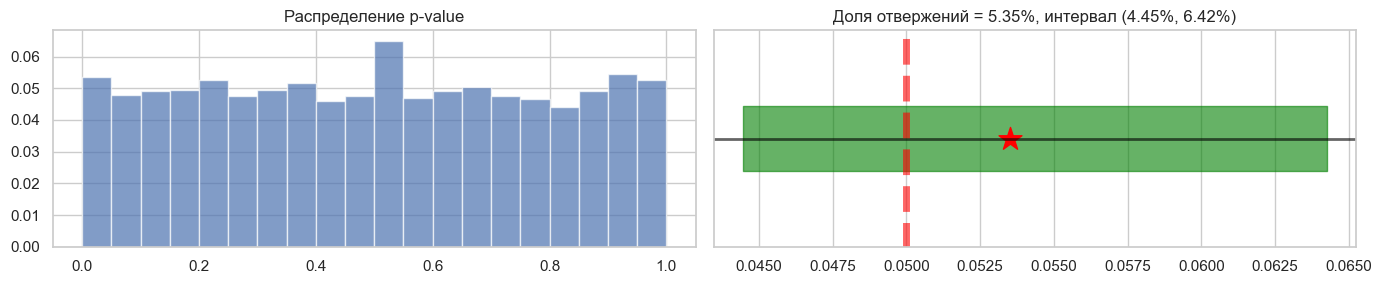

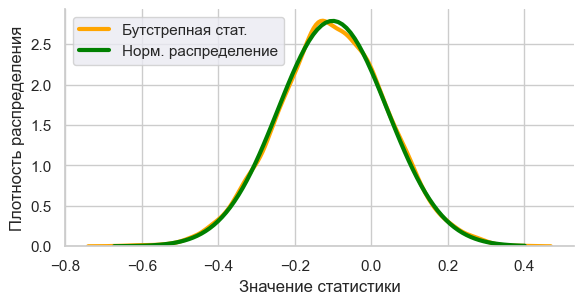

Размер выборки: 1000


  0%|          | 0/2000 [00:00<?, ?it/s]

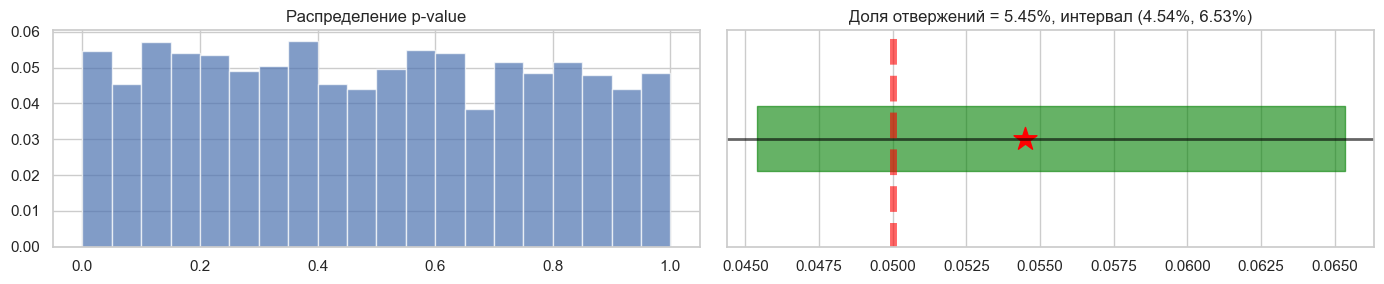

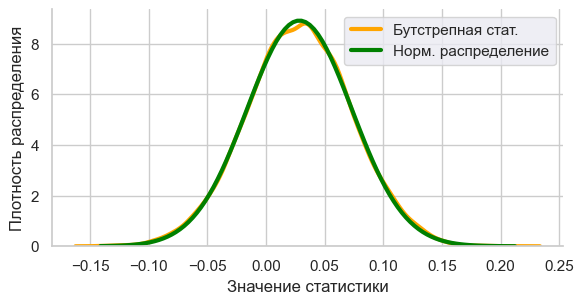

In [ ]:
sample_sizes = [10, 100, 1000]
for sample_size in sample_sizes:
    print(f'Размер выборки: {sample_size}')
    run_experiments_AA(test=lambda x, y: ttest_bootstrap(x, y, B=10_000,
                                        relative=False, return_bootstrap_stats=True),
            generate_sample=lambda: generate_data_from_distrs(sps.norm, sps.norm,
                                                              sample_size=sample_size),
            n_iter=n_iter,
            alpha=alpha,
            show_pvals=True
    );

### b. Относительный бутстрепный t-test.

#### Экспоненциальное распределение

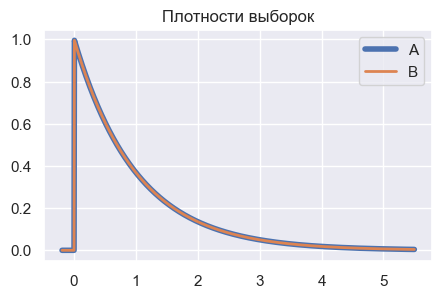

In [ ]:
vizualize_distributions(sps.expon, sps.expon)

Размер выборки: 10


  0%|          | 0/2000 [00:00<?, ?it/s]

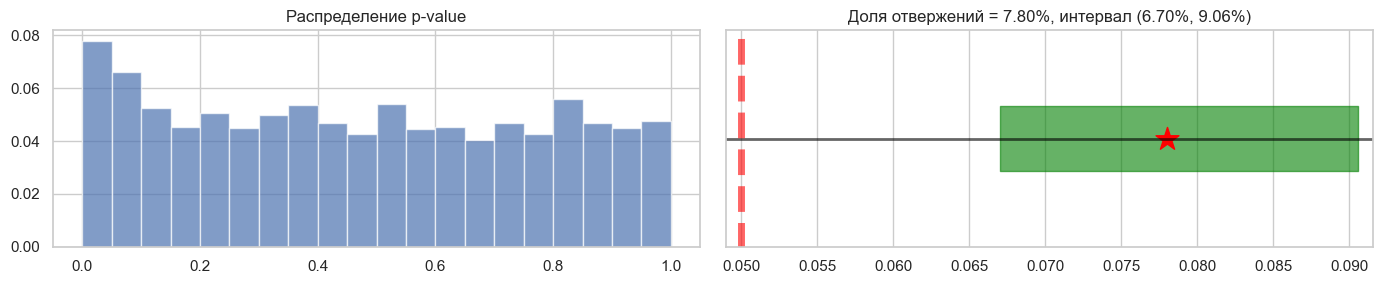

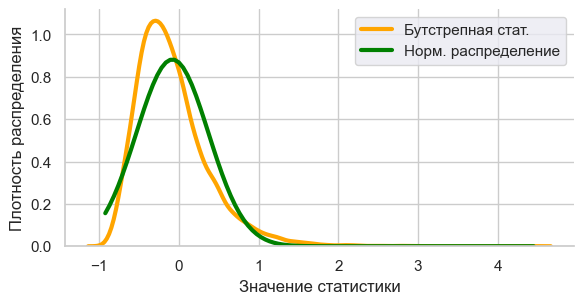

Размер выборки: 100


  0%|          | 0/2000 [00:00<?, ?it/s]

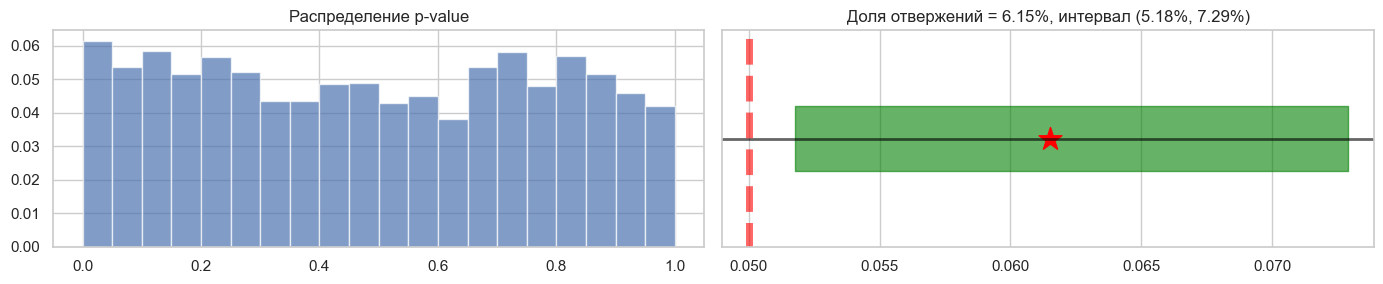

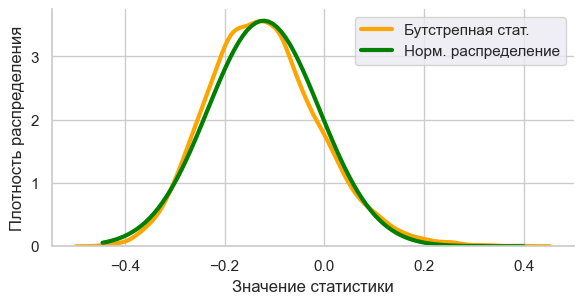

Размер выборки: 1000


  0%|          | 0/2000 [00:00<?, ?it/s]

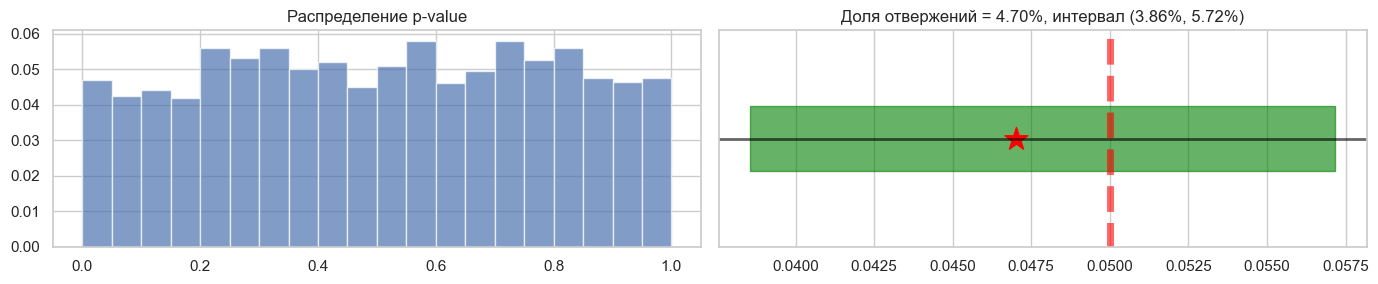

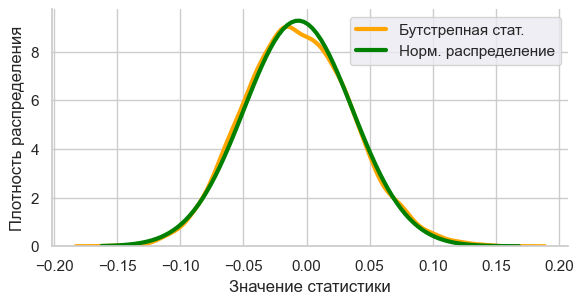

In [ ]:
sample_sizes = [10, 100, 1000]
for sample_size in sample_sizes:
    print(f'Размер выборки: {sample_size}')
    run_experiments_AA(test=lambda x, y: ttest_bootstrap(x, y, B=10_000,
                                        relative=True, return_bootstrap_stats=True),
            generate_sample=lambda: generate_data_from_distrs(sps.expon, sps.expon,
                                                              sample_size=sample_size),
            n_iter=n_iter,
            alpha=alpha,
            show_pvals=True
    );

#### Гамма-распределение

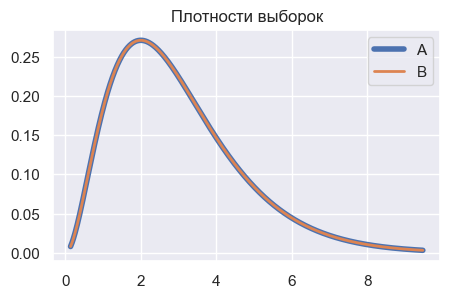

In [ ]:
vizualize_distributions(sps.gamma(a=3), sps.gamma(a=3))

Размер выборки: 10


  0%|          | 0/2000 [00:00<?, ?it/s]

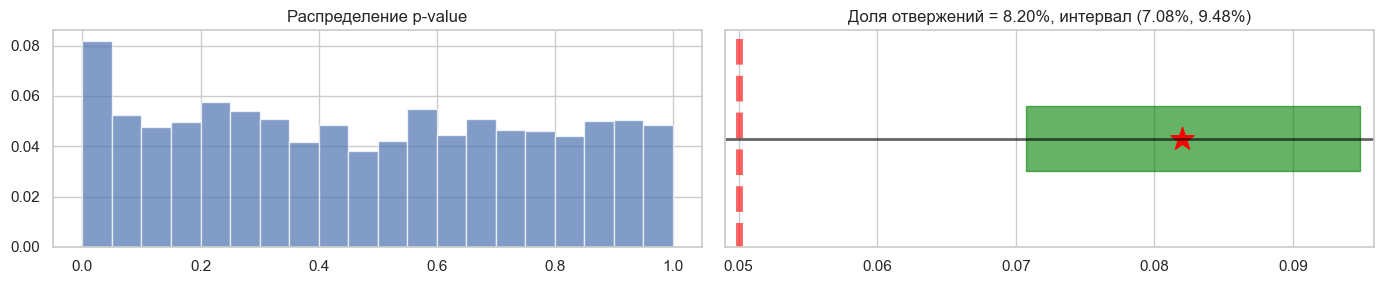

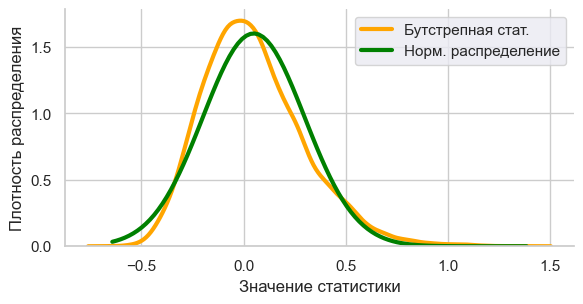

Размер выборки: 100


  0%|          | 0/2000 [00:00<?, ?it/s]

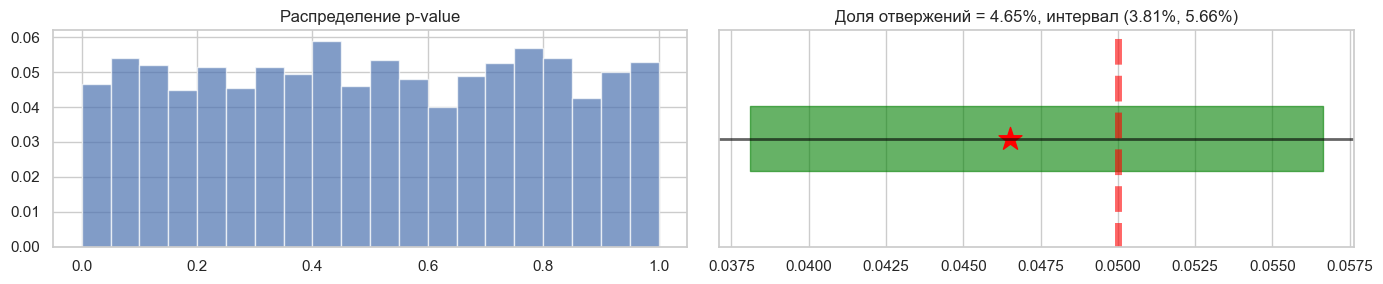

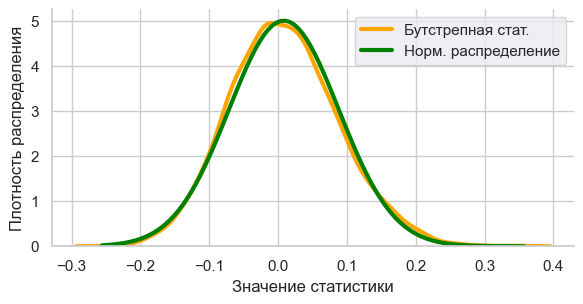

Размер выборки: 1000


  0%|          | 0/2000 [00:00<?, ?it/s]

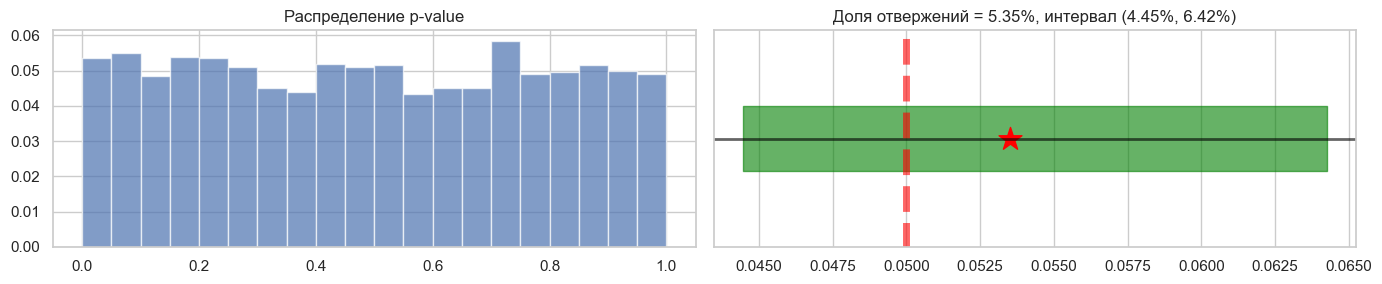

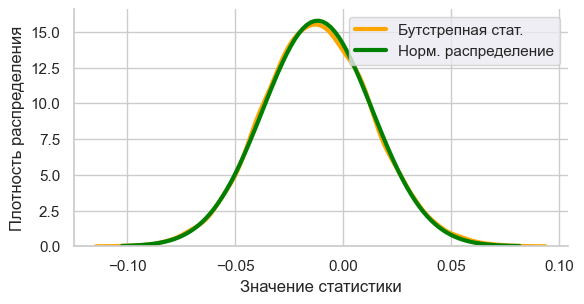

In [ ]:
sample_sizes = [10, 100, 1000]
for sample_size in sample_sizes:
    print(f'Размер выборки: {sample_size}')
    run_experiments_AA(test=lambda x, y: ttest_bootstrap(x, y, B=10_000,
                                        relative=True, return_bootstrap_stats=True),
            generate_sample=lambda: generate_data_from_distrs(sps.gamma(a=3), sps.gamma(a=3),
                                                              sample_size=sample_size),
            n_iter=n_iter,
            alpha=alpha,
            show_pvals=True
    );

#### Распределение Коши

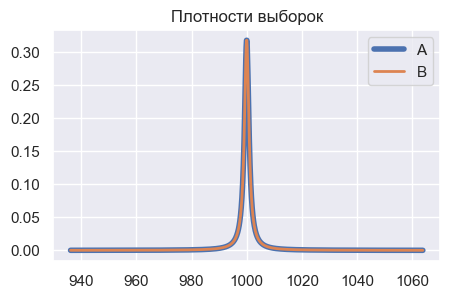

In [ ]:
vizualize_distributions(sps.cauchy(loc=1000), sps.cauchy(loc=1000))

Размер выборки: 10


  0%|          | 0/2000 [00:00<?, ?it/s]

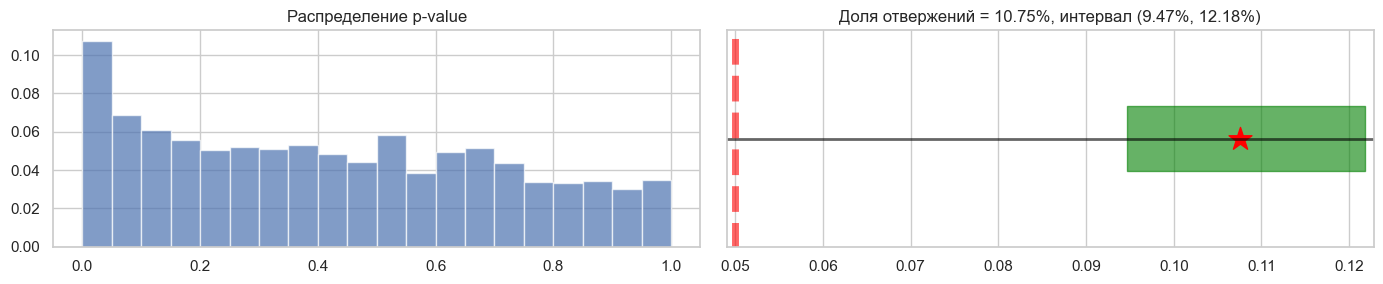

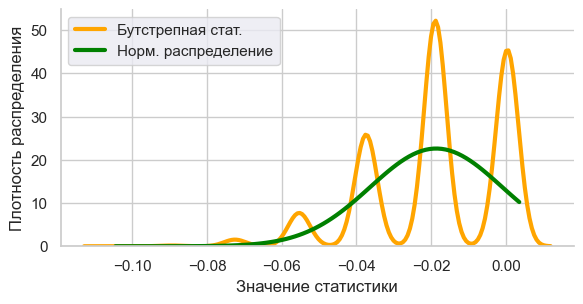

Размер выборки: 100


  0%|          | 0/2000 [00:00<?, ?it/s]

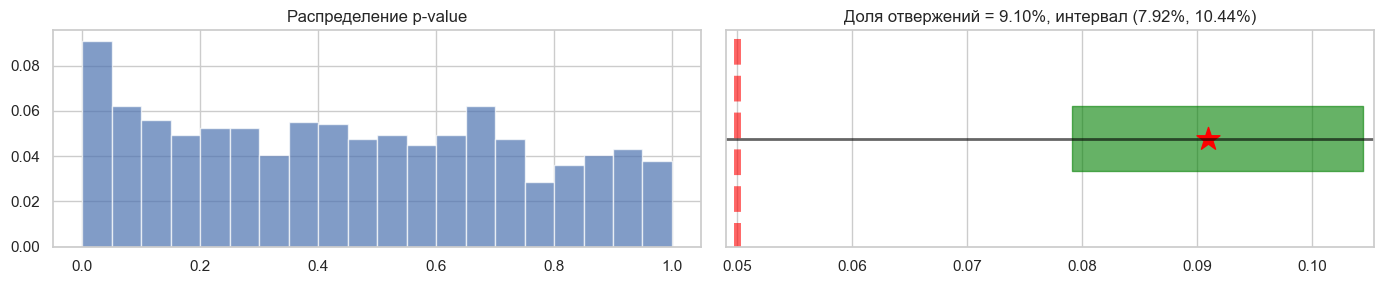

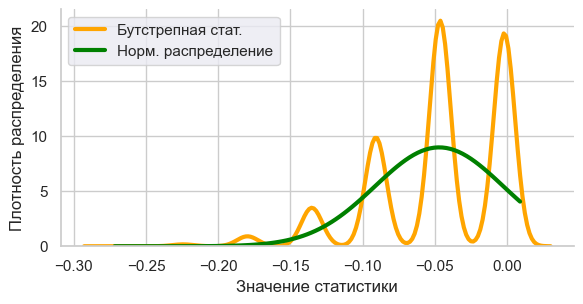

Размер выборки: 1000


  0%|          | 0/2000 [00:00<?, ?it/s]

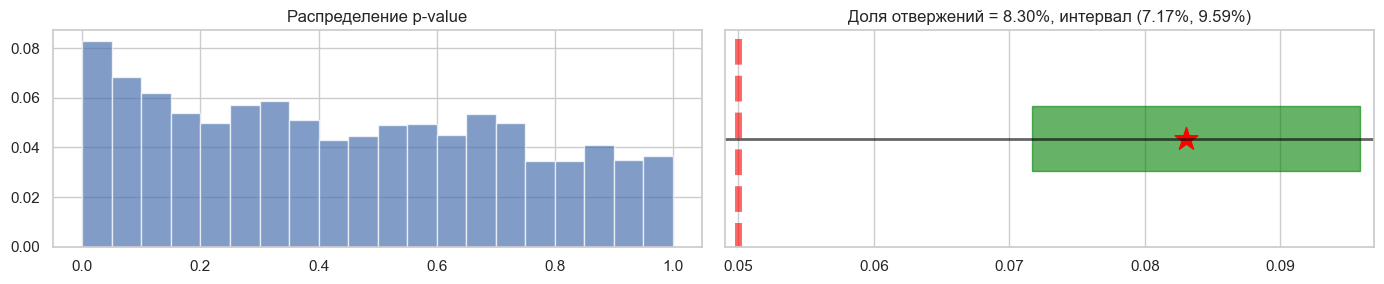

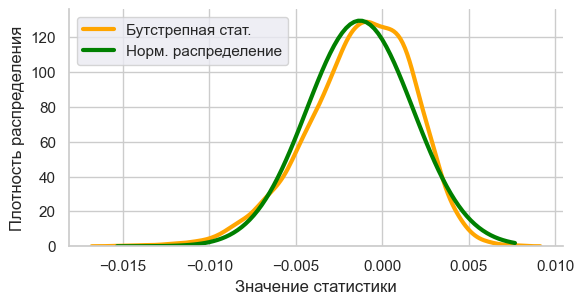

In [ ]:
sample_sizes = [10, 100, 1000]
for sample_size in sample_sizes:
    print(f'Размер выборки: {sample_size}')
    run_experiments_AA(test=lambda x, y: ttest_bootstrap(x, y, B=10_000,
                                        relative=True, return_bootstrap_stats=True),
            generate_sample=lambda: generate_data_from_distrs(sps.cauchy(loc=1000),
                                                              sps.cauchy(loc=1000),
                                                              sample_size=sample_size),
            n_iter=n_iter,
            alpha=alpha,
            show_pvals=True
    );

#### Нормальное распределение

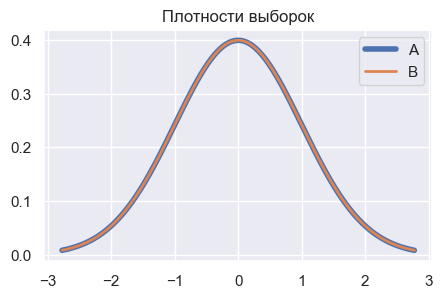

In [ ]:
vizualize_distributions(sps.norm, sps.norm)

Размер выборки: 10


  0%|          | 0/2000 [00:00<?, ?it/s]

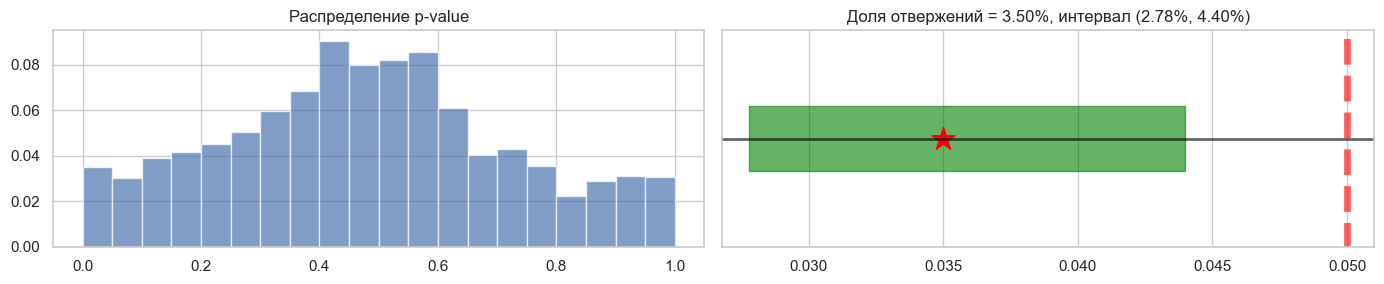

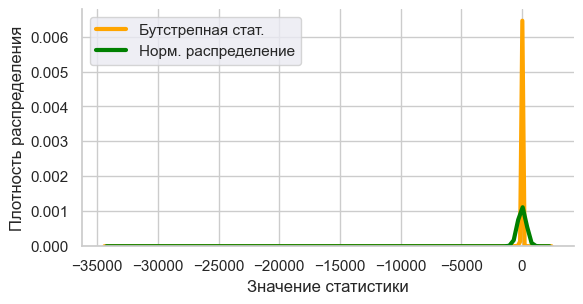

Размер выборки: 100


  0%|          | 0/2000 [00:00<?, ?it/s]

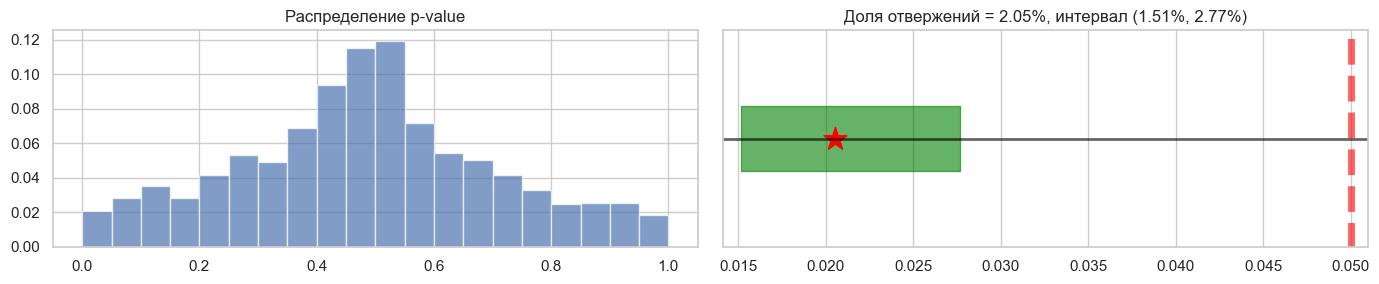

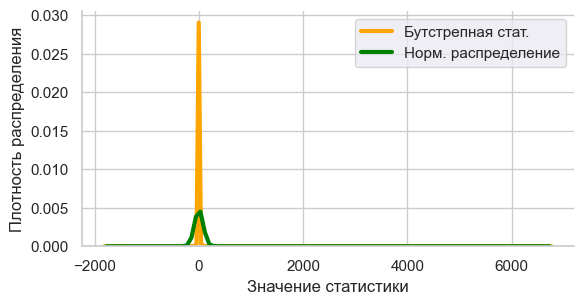

Размер выборки: 1000


  0%|          | 0/2000 [00:00<?, ?it/s]

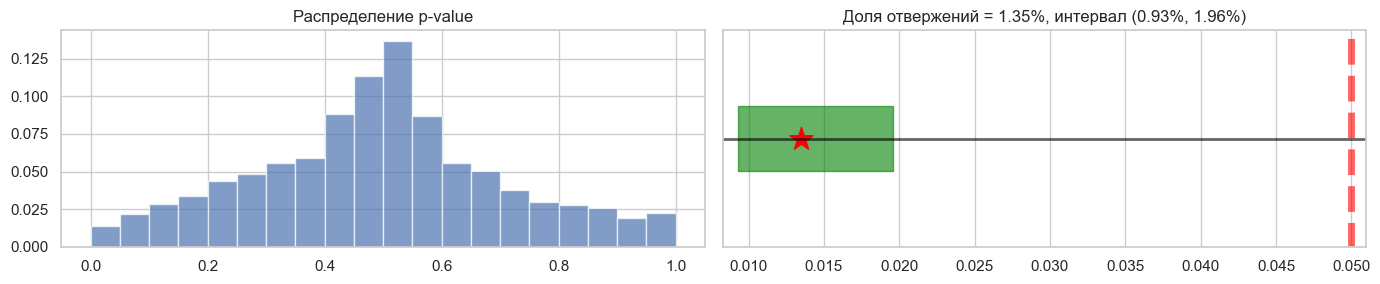

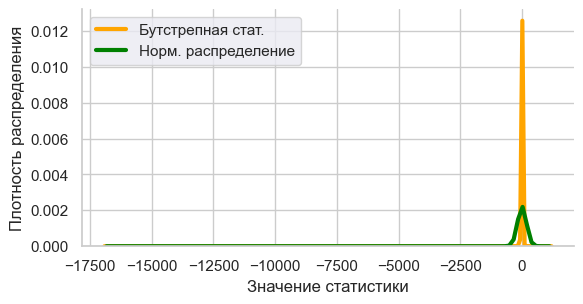

In [ ]:
sample_sizes = [10, 100, 1000]
for sample_size in sample_sizes:
    print(f'Размер выборки: {sample_size}')
    run_experiments_AA(test=lambda x, y: ttest_bootstrap(x, y, B=10_000,
                                        relative=True, return_bootstrap_stats=True),
            generate_sample=lambda: generate_data_from_distrs(sps.norm, sps.norm,
                                                              sample_size=sample_size),
            n_iter=n_iter,
            alpha=alpha,
            show_pvals=True
    );

## 2. Данные с прошлой задачи.

### a. Абсолютный бутстрепный t-test

  0%|          | 0/2000 [00:00<?, ?it/s]

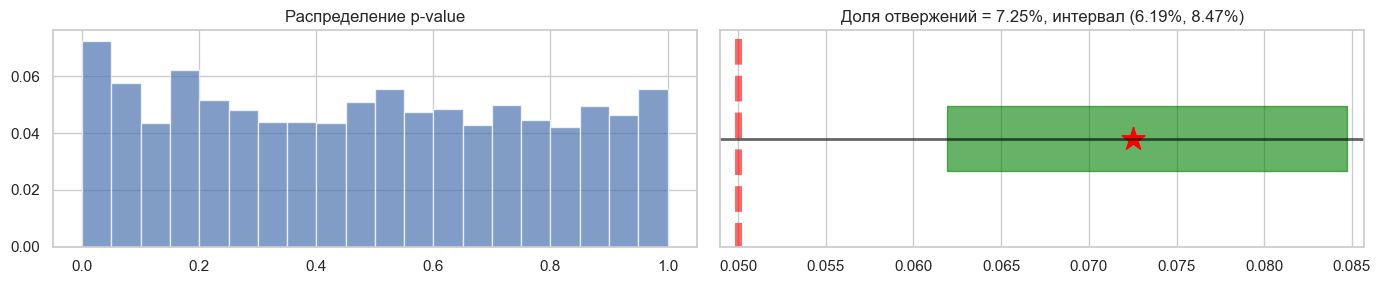

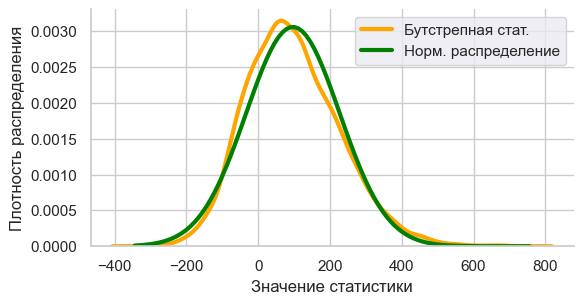

In [ ]:
run_experiments_AA(test=lambda x, y: ttest_bootstrap(
                x[target_column], y[target_column], B=10_000,
                relative=False, return_bootstrap_stats=True),
    generate_sample=lambda data: generate_from_data(data, size_gen=group_size),
    data=data_m,
    n_iter=n_iter,
    alpha=alpha,
    show_pvals=True
);

### b. Относительный бутстрепный t-test

  0%|          | 0/2000 [00:00<?, ?it/s]

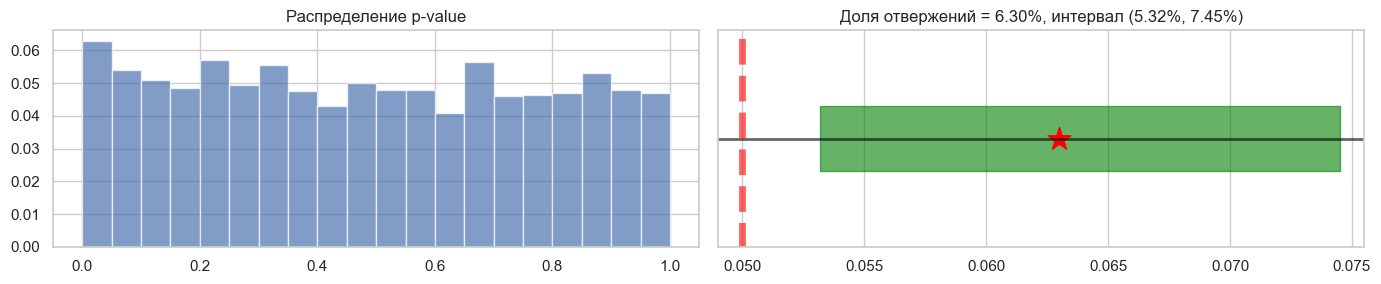

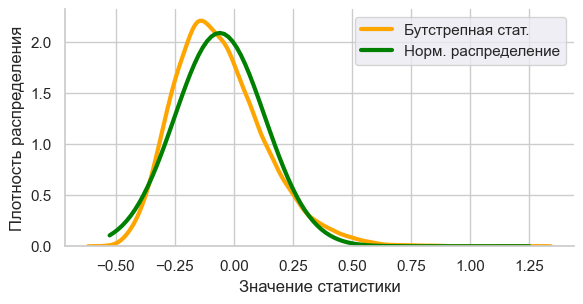

In [ ]:
run_experiments_AA(test=lambda x, y: ttest_bootstrap(
                x[target_column], y[target_column], B=10_000,
                relative=True, return_bootstrap_stats=True),
    generate_sample=lambda data: generate_from_data(data, size_gen=group_size),
    data=data_m,
    n_iter=n_iter,
    alpha=alpha,
    show_pvals=True
);

# Оценка мощности.

## 1. Эксперименты на искусственных данных

### a. Абсолютный бутстрепный t-test

In [ ]:
n_iter = 500

Размер выборки: 10


0it [00:00, ?it/s]

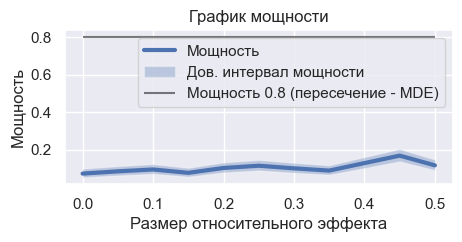

Размер выборки: 100


0it [00:00, ?it/s]

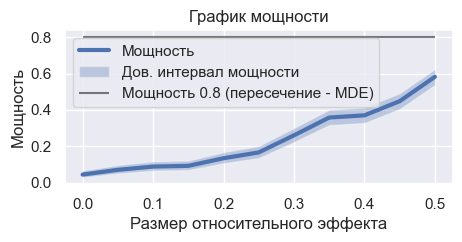

Размер выборки: 1000


0it [00:00, ?it/s]

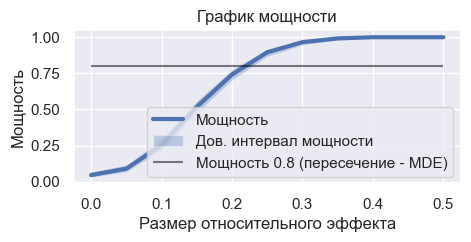

In [ ]:
sample_sizes = [10, 100, 1000]
for sample_size in sample_sizes:
    print(f'Размер выборки: {sample_size}')
    run_experiments(test=lambda x, y: ttest_bootstrap(x, y, B=10_000,
                relative=False, return_bootstrap_stats=True),
            generate_sample=lambda: generate_data_from_distrs(sps.gamma(a=3),
                                                              sps.gamma(a=3),
                                                              sample_size=sample_size),
            effects=np.linspace(0, 0.5, 11),
            add_effect=add_effect,
            n_iter=n_iter,
            alpha=alpha,
    );

### b. Относительный бутстрепный t-test

Размер выборки: 10


0it [00:00, ?it/s]

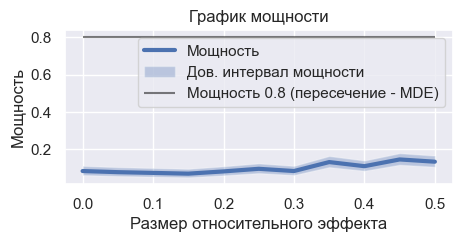

Размер выборки: 100


0it [00:00, ?it/s]

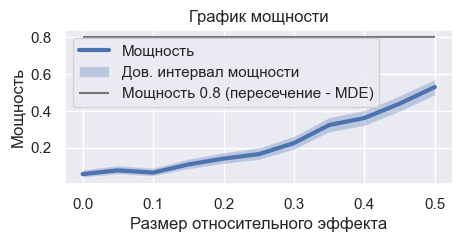

Размер выборки: 1000


0it [00:00, ?it/s]

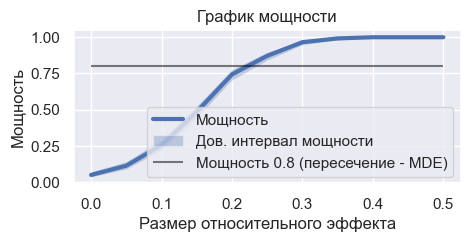

In [ ]:
sample_sizes = [10, 100, 1000]
for sample_size in sample_sizes:
    print(f'Размер выборки: {sample_size}')
    run_experiments(test=lambda x, y: ttest_bootstrap(
                x, y, B=10_000,
                relative=True, return_bootstrap_stats=True),
        generate_sample=lambda: generate_data_from_distrs(sps.gamma(a=3),
                                                          sps.gamma(a=3),
                                                          sample_size=sample_size),
        effects=np.linspace(0, 0.5, 11),
        add_effect=add_effect,
        n_iter=n_iter,
        alpha=alpha,
    );

## 2. Данные с прошлой задачи.

### a. Абсолютный бутстрепный t-test

0it [00:00, ?it/s]

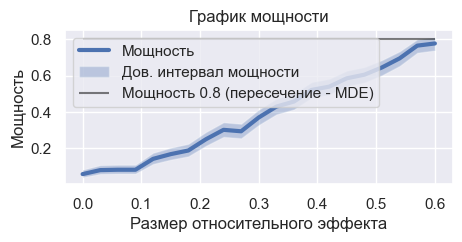

In [ ]:
run_experiments(test=lambda x, y: ttest_bootstrap(
                x[target_column], y[target_column], B=10_000,
                relative=False, return_bootstrap_stats=True),
        generate_sample=lambda data: generate_from_data(data, size_gen=group_size),
        data=data_m,
        effects=effects,
        add_effect=lambda x, e: add_effect_with_noise(x, e, target_column=target_column),
        n_iter=n_iter,
        alpha=alpha
);

### b. Относительный бутстрепный t-test

0it [00:00, ?it/s]

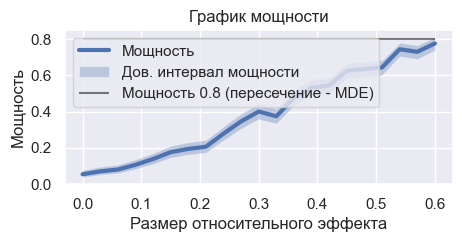

In [ ]:
run_experiments(test=lambda x, y: ttest_bootstrap(
                x[target_column], y[target_column], B=10_000,
                relative=True, return_bootstrap_stats=True),
        generate_sample=lambda data: generate_from_data(data, size_gen=group_size),
        data=data_m,
        effects=effects,
        add_effect=lambda x, e: add_effect_with_noise(x, e, target_column=target_column),
        n_iter=n_iter,
        alpha=alpha
);

**Вывод:** мы написали бутстрепные абсолютный и относительный t-test'ы и провалидировали их работу на синтетических данных и на исторических реальных данных.

Если говорить о результатах на синтетике, то они получились похожими с относительным t-test. Стоит отметить, что при малых размерах выборки ближе к нормальному распределение статистики абсолютного критерия, поэтому ожидаемо, что абсолютный t-test быстрее начинает контролировать вероятность ошибки первого рода.

Если сравнивать результаты на реальных данных с предыдущей задачей, то стоит отметить, что мощность показана сопоставимой, при этом оба критерия не контролируют вероятность ошибки первого рода, поэтому в таком виде их нельзя применять.